# Decomposition Tutorial

This tutorial will show you how to load a geometry from an STL file, create a grid object using this geometry, and then to decompose the grid into load-balanced domains.

First, load a geometry and visualize it.

<Axes3D: >

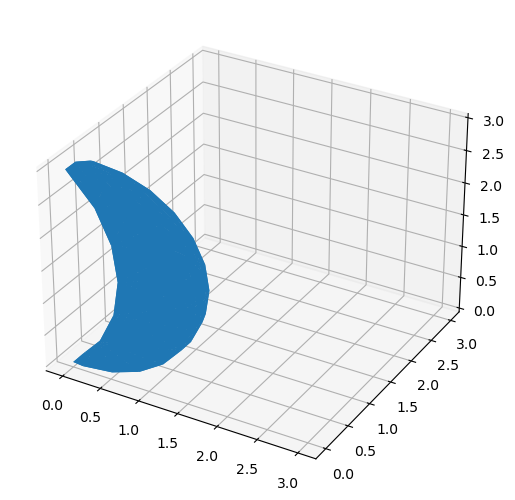

In [1]:
from slagg.grid import Geometry

geometry = Geometry("../tests/stl_files/Moon.stl")
geometry.plot()

Next, we create a grid to discretize this geometry.  The grid is made up of cells, some of which lie inside the geometry and others are outside.  We assume that the desired simulation domain is inside the object.  Providing the Grid with a Geometry object will calculate intersections and mark all cells interior to the object.

Found geometry bounds:
start positions:  [0. 0. 0.]
end positions:    [1.62840998 0.34999999 3.        ]

Using geometry to determine the grid size:
start positions:  [-0.0814205 -0.0175    -0.15     ]
end positions:    [1.70983048 0.36749999 3.15      ]

Initializing Grid with [30  8 60] cells
Checking 116 triangles in geometry for intersection with 14400 grid cells.



<Axes3D: >

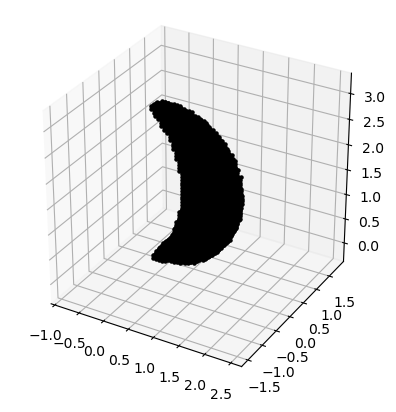

In [3]:
from slagg.grid import Grid
grid = Grid((30, 8, 60), geometry=geometry)
grid.plot()

The above plot shows only the cells that contain geometry.

Now, we want to generate a decomposition for this grid.  The standard, default decomposition generates regions that are as cubic and equal in volume as possible, based on the number of regions desired and the number of cells in the grid.  With complex geometries, this is often not a good, load-balanced decomposition.

32 slabs broken into prime factors: [2, 2, 2, 2, 2]
domain_size = [7 8 7]
num_domains = [4 1 8]
Domain decomposed into slabs:
lb: [0 0 0], ub: [7 8 7]
lb: [7 0 0], ub: [14  8  7]
lb: [14  0  0], ub: [21  8  7]
lb: [21  0  0], ub: [30  8  7]
lb: [0 0 7], ub: [ 7  8 14]
lb: [7 0 7], ub: [14  8 14]
lb: [14  0  7], ub: [21  8 14]
lb: [21  0  7], ub: [30  8 14]
lb: [ 0  0 14], ub: [ 7  8 21]
lb: [ 7  0 14], ub: [14  8 21]
lb: [14  0 14], ub: [21  8 21]
lb: [21  0 14], ub: [30  8 21]
lb: [ 0  0 21], ub: [ 7  8 28]
lb: [ 7  0 21], ub: [14  8 28]
lb: [14  0 21], ub: [21  8 28]
lb: [21  0 21], ub: [30  8 28]
lb: [ 0  0 28], ub: [ 7  8 35]
lb: [ 7  0 28], ub: [14  8 35]
lb: [14  0 28], ub: [21  8 35]
lb: [21  0 28], ub: [30  8 35]
lb: [ 0  0 35], ub: [ 7  8 42]
lb: [ 7  0 35], ub: [14  8 42]
lb: [14  0 35], ub: [21  8 42]
lb: [21  0 35], ub: [30  8 42]
lb: [ 0  0 42], ub: [ 7  8 49]
lb: [ 7  0 42], ub: [14  8 49]
lb: [14  0 42], ub: [21  8 49]
lb: [21  0 42], ub: [30  8 49]
lb: [ 0  0 49], ub: [

<Axes3D: >

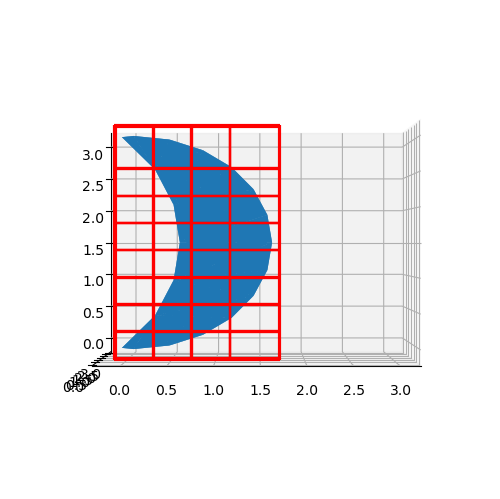

In [10]:
from slagg.grid import Decomp
N_desired_domains = 32
decomp = Decomp(grid, N_desired_domains, geometry_biased=False)
ax = geometry.plot(plot=False)
ax.view_init(elev=0, azim=-90, roll=0)
decomp.plot(axes=ax)

The above decomposition does not take into accout any geometries, but just seeks to make domains with a balanced number of cells.  If instead, we seek to balance the number of geometry-containing cells, a better decomposition results:

32 slabs broken into prime factors: [2, 2, 2, 2, 2]
domain_size = [7 8 7]
num_domains = [4 1 8]
Domain decomposed into slabs:
lb: [0 0 0], ub: [7 8 7]
lb: [7 0 0], ub: [14  8  7]
lb: [14  0  0], ub: [21  8  7]
lb: [21  0  0], ub: [30  8  7]
lb: [0 0 7], ub: [ 7  8 14]
lb: [7 0 7], ub: [14  8 14]
lb: [14  0  7], ub: [21  8 14]
lb: [21  0  7], ub: [30  8 14]
lb: [ 0  0 14], ub: [ 7  8 21]
lb: [ 7  0 14], ub: [14  8 21]
lb: [14  0 14], ub: [21  8 21]
lb: [21  0 14], ub: [30  8 21]
lb: [ 0  0 21], ub: [ 7  8 28]
lb: [ 7  0 21], ub: [14  8 28]
lb: [14  0 21], ub: [21  8 28]
lb: [21  0 21], ub: [30  8 28]
lb: [ 0  0 28], ub: [ 7  8 35]
lb: [ 7  0 28], ub: [14  8 35]
lb: [14  0 28], ub: [21  8 35]
lb: [21  0 28], ub: [30  8 35]
lb: [ 0  0 35], ub: [ 7  8 42]
lb: [ 7  0 35], ub: [14  8 42]
lb: [14  0 35], ub: [21  8 42]
lb: [21  0 35], ub: [30  8 42]
lb: [ 0  0 42], ub: [ 7  8 49]
lb: [ 7  0 42], ub: [14  8 49]
lb: [14  0 42], ub: [21  8 49]
lb: [21  0 42], ub: [30  8 49]
lb: [ 0  0 49], ub: [

<Axes3D: >

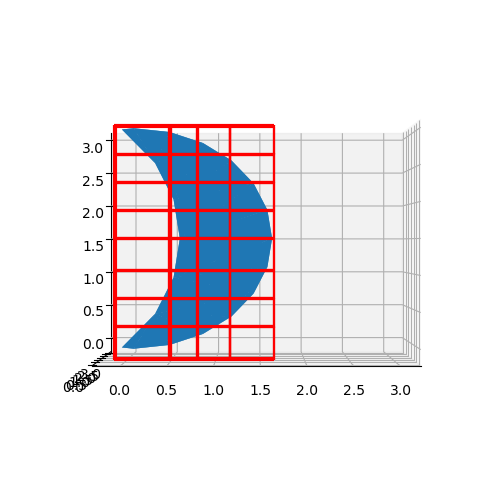

In [9]:
decomp = Decomp(grid, N_desired_domains, geometry_biased=True)
ax = geometry.plot(plot=False)
ax.view_init(elev=0, azim=-90, roll=0)
decomp.plot(axes=ax)

This decomp attempts to balance the number of geometry-containing cells in each row and column of domains.  However, there are still issues in the above decomposition.  There are multiple domains that have zero geometry-containing cells in them.  If each domain is given to a single CPU-core, then there will be multiple cores doing nothing, thus being wasted.

To resolve this, we can refine the decomp further:

After initial refinement, 32 slabs remaining.

Slab bounds: 
[14  0  5]
[17  8  7]
 is 2.10 standard deviations below the average volume. Attempting to merge with neighbor.
After initial refinement, 31 slabs remaining.

Splitting slab: Slab bounds: 
[14  0 14]
[21  8 21]

Slab split into two: Slab bounds: 
[14  0 14]
[21  7 21]
  Slab bounds: 
[14  7 14]
[21  8 21]

Largest slabs split to create 32 total slabs.
After initial refinement, 32 slabs remaining.

Merged successfully

 ========== Summary ==========

-- Memory --
Initial domain volume: 14400
Final domain volume: 7794
Results in 54.1% memory usage.


-- Efficiency --
Before Refinement:
32 total domains
Average 450.0 cells per domain
Average 90.2 cells per domain containing geometry
Largest slab has 178.0 cells containing geometry
57.0 standard deviation of cells per domain containing geometry

After Refinement:
32 total domains
Average 243.6 cells per domain
Average 90.2 cells per domain containing geometry
Largest slab has 141

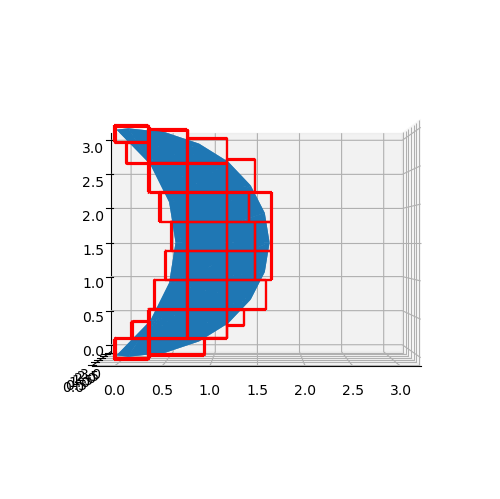

<Axes3D: >

In [12]:
decomp.refine()
ax = geometry.plot(plot=False)
ax.view_init(elev=0, azim=-90, roll=0)
decomp.plot(axes=ax, plot=True)